### Use Keras to build CNN model 

In [1]:
import pandas as pd

filepath_dict = {'yelp':   'sentiment_data/yelp_labelled.txt',
                 'amazon': 'sentiment_data/amazon_cells_labelled.txt',
                 'imdb':   'sentiment_data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [2]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


#### split data into training and testing 

In [3]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

#### Vectorization

In [4]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

#### use padding to make sure each sentence have the same length vector representation 

In [5]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100  # for each sentence, the length of the vector = 100 

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [6]:
## function used to plot the results 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

#### Convolutional Neural Networks (CNN)

CNN is able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. You can imagine a CNN as a specialized neural network that is able to detect specific patterns.

A CNN has hidden layers which are called **convolutional layers**. 

When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. You still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.

In the next figure you can see how such a convolution works. It starts by taking a patch of input features with the size of the filter kernel. With this patch you take the dot product of the multiplied weights of the filter. The one dimensional convnet is invariant to translations, which means that certain sequences can be recognized at a different position.

<img src="https://files.realpython.com/media/njanakiev-1d-convolution.d7afddde2776.png" width=460 height=260 />

Please check different layers of CNN using keras: 

    https://keras.io/api/layers/convolution_layers/


In [8]:
from keras.models import Sequential
from keras import layers

embedding_dim = 100
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))

######################################################
# the number of filters = 128
# the kernel size = 5 
# the activation function = relu 
model.add(layers.Conv1D(128, 5, activation='relu')) 
# pooling layer 
model.add(layers.GlobalMaxPooling1D())
######################################################

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          174700    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 240,129
Trainable params: 240,129
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8240


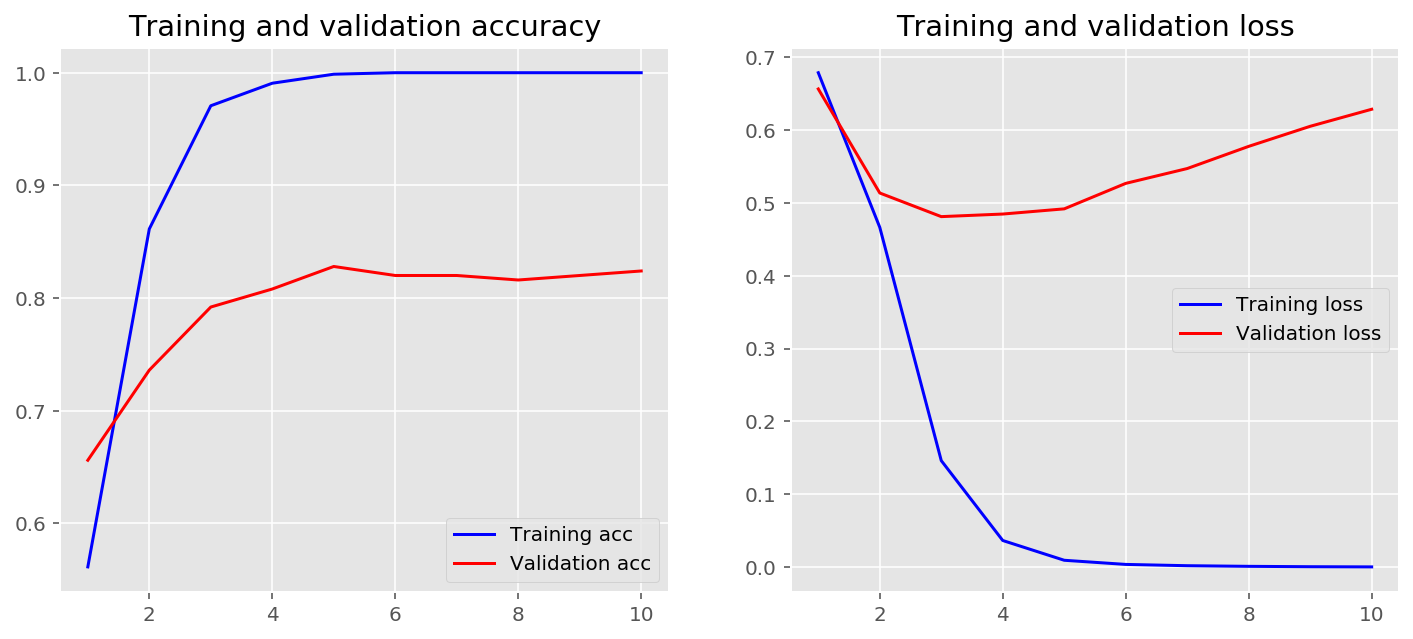

In [9]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)


loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

You can see that 80% accuracy seems to be tough hurdle to overcome with this data set and a CNN might not be well equipped. The reason for such a plateau might be that:

* There are not enough training samples
* The data you have does not generalize well
* Missing focus on tweaking the hyperparameters

CNNs work best with large training sets where they are able to find generalizations where a simple model like logistic regression won’t be able.